In [1]:
import pandas as pd
import numpy as np
import os
import sys
from sklearn.linear_model import LinearRegression
chemin_dev = os.path.abspath(os.path.join(os.getcwd(), '../..'))
if chemin_dev not in sys.path:
    sys.path.append(chemin_dev)
from options_pricing.scripts import data_processing as dp
from options_pricing.scripts import black_scholes as bs
from options_pricing.scripts import linear_reg as lr
from matplotlib import pyplot as plt
from scipy.stats import norm, shapiro
import statsmodels.api as sm

In [2]:
df_options = pd.read_csv('../../data/options/options_processed.csv')
df_options_c = df_options.loc[df_options['call_put'] == 'Call']

In [3]:
params = {
    'test_size' : 0.1, # If we choose 0, we test on all the rest of the data (not used for training or validation
    'n_rows' : 10000,
    'standardize' : False,
    'fit_intercept' : True, # Default is True but our data are already centered 'If set to False, no intercept will be used in calculations (i.e. data is expected to be centered).'
    'features': ['strike','vol', 'delta', 'gamma', 'theta', 'vega', 'rho', 'stock_price','time_to_maturity', 'interest_rate'],
}

In [4]:
X_train, X_test, y_train, y_test, scaler = dp.create_train_test_set_by_act_symbol(
    df_options_c,
    params['test_size'],
    params['n_rows'], 
    params['features'],
    params['standardize']
    )
# The explicative variables are scaled and standardized

In [5]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((9425, 10), (1048, 10), (9425,), (1048,))

In [6]:
lin_reg_model = LinearRegression(fit_intercept=params['fit_intercept'])

In [7]:
lin_reg_model.fit(X_train, y_train)

LinearRegression()

In [8]:
y_pred = lin_reg_model.predict(X_test)
bs.compute_metrics(y_test, y_pred)

MAPE:  13.807881066356066
MAE:  5.817440882200349
MSE:  107.8532636393608
R2:  0.9584313927014882
-----------------------------------




(13.807881066356066, 5.817440882200349, 107.8532636393608, 0.9584313927014882)

The first observation, regarding the parameters standardize & fit_intercept is 

| standardize      | fit_intercept      | MSE      |
| -------------- | -------------- | -------------- |
| False | True |  8.3346 |
| True | True | 8.3346 |
| False | False | 8.3571 |
| True | False | 38.1083 |


## Assessment of fit quality

In [9]:
r2 = lin_reg_model.score(X_test, y_test)
print(r2)

0.9584313927014882


## Residuals analysis

In [10]:
y_pred_train = lin_reg_model.predict(X_train)

In [11]:
p = len(params['features'])
standardized_residuals = lr.compute_standardized_residuals_fast(X_train, y_train, y_pred_train, p)

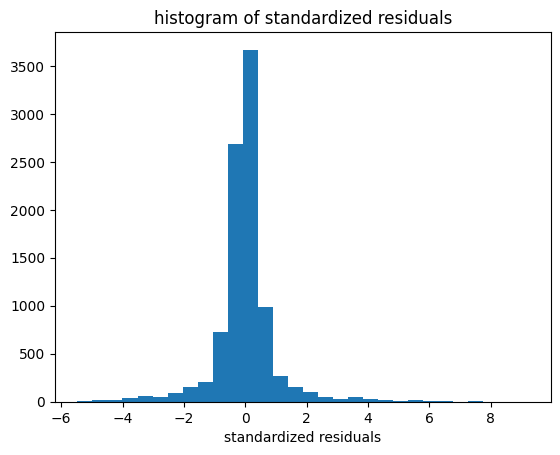

In [12]:
plt.hist(standardized_residuals, bins=30)
plt.xlabel('standardized residuals')
plt.title('histogram of standardized residuals')
plt.show()

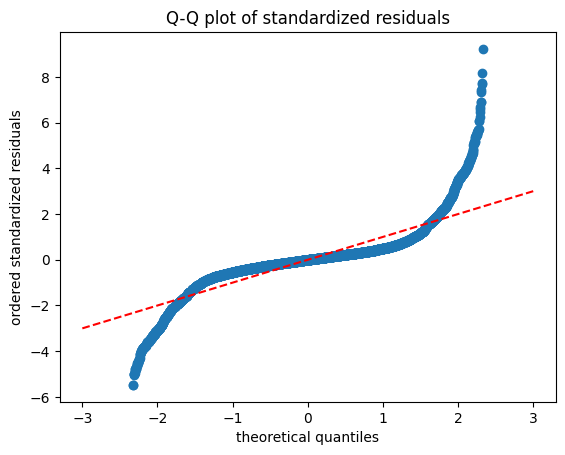

In [13]:
theoretical_quantiles = norm.ppf(np.linspace(0.01, 0.99, len(standardized_residuals)))
residuals_sorted = np.sort(standardized_residuals)
plt.scatter(theoretical_quantiles, residuals_sorted)
plt.xlabel('theoretical quantiles')
plt.ylabel('ordered standardized residuals')
plt.title('Q-Q plot of standardized residuals')
plt.plot([-3, 3], [-3, 3], color='red', linestyle='--')


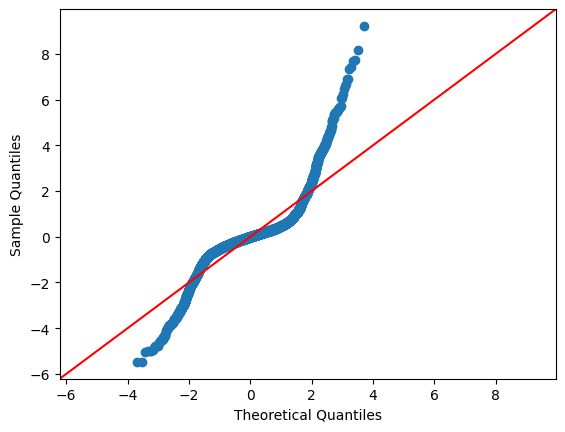

In [17]:
sm.qqplot(standardized_residuals, line ='45')
plt.show()

In [15]:
_, p_value  = shapiro(standardized_residuals)
print(p_value)

8.3638052296294e-75


/Users/ambroisethibault/Documents/Cours/TX/survey-ml-finance/venv_tx/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 9425.
  res = hypotest_fun_out(*samples, **kwds)


Text(0, 0.5, 'standardized residuals')

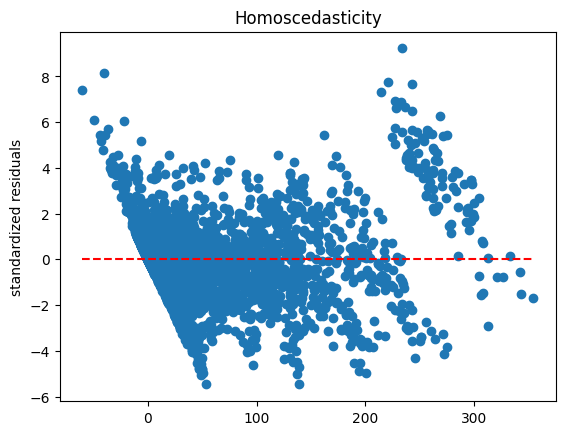

In [16]:
plt.scatter(y_pred_train, standardized_residuals)
plt.plot([min(y_pred_train), max(y_pred_train)], [0, 0], color='red', linestyle='--')
plt.title('Homoscedasticity')
plt.ylabel('standardized residuals')